# Add meta data to the TS Corrected 2021 Prawler Dataset

- Prawler data has been a fairly unique platform in its early deployments so each notebook may have distinct sections.
- This one is devoted to giving metadata to an already corrected 2021 dataset

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import datetime

import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

In [27]:
import xarray as xa

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [28]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2021/Moorings/21bspr2a/'

In [29]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'working/datasets_Mooring_21bspr2a_final.TS_corr.nc'
instrument = 'Prawler '
mooring_meta_file = user_data_dir+'logs/21BSPR-2A.yaml'
inst_meta_file = '21bspr2a_prawler_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'met'
###############################################################

#init and load data
praw_nc = xa.load_dataset(datafile)

In [30]:
praw_nc = praw_nc.rename({'index':'depth','datetime':'time'}) #dims

In [31]:
praw_nc = praw_nc.rename({'Chlorophyll':'chlor_fluorescence',
                          'Temperature':'temperature',
                          'Salinity (PSU) bsm2a corrected':'salinity',
                          'Turbidity':'turbidity',
                          'Oxy_Sat':'oxy_percentsat',
                          'Oxy_Conc_aandT':'oxy_conc_umkg',
                         }) #vars - using corrected temp and 

In [32]:
praw_nc

<xarray.Dataset>
Dimensions:             (time: 6401, depth: 51)
Coordinates:
  * time                (time) datetime64[ns] 2021-05-05T05:00:00 ... 2022-01...
  * depth               (depth) int32 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
Data variables:
    Salinity_aandT      (time, depth) float64 nan nan nan 32.16 ... nan nan nan
    Salinity            (time, depth) float64 nan nan nan 32.21 ... nan nan nan
    temperature         (time, depth) float64 nan nan nan 2.637 ... nan nan nan
    Oxy_Temperature     (time, depth) float64 nan nan nan 2.687 ... nan nan nan
    Conductivity        (time, depth) float64 nan nan nan 2.907 ... nan nan nan
    chlor_fluorescence  (time, depth) float64 nan nan nan 0.9288 ... nan nan nan
    Oxy_Conc            (time, depth) float64 nan nan nan 306.6 ... nan nan nan
    oxy_percentsat      (time, depth) float64 nan nan nan 92.22 ... nan nan nan
    oxy_conc_umkg       (time, depth) float64 nan nan nan 306.7 ... nan nan nan
    turbidity           (time, depth) float64 nan nan nan 16.68 ... nan nan nan
    salinity            (time, depth) float64 nan nan nan 32.21 ... nan nan nan

In [33]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [34]:
mooring_config['Instrumentation'][instrument]

{'InstType': 'Prawler',
 'SerialNo': '',
 'DesignedDepth': 2.0,
 'ActualDepth': 0.0,
 'PreDeploymentNotes': 'M2 FOCI Main (M200)',
 'PostDeploymentNotes': '',
 'Deployed': 'y',
 'Recovered': 'y'}

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [35]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [36]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [37]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
praw_nc = praw_nc.expand_dims(['latitude','longitude'])

In [38]:
list(praw_nc.keys())

['Salinity_aandT',
 'Salinity',
 'temperature',
 'Oxy_Temperature',
 'Conductivity',
 'chlor_fluorescence',
 'Oxy_Conc',
 'oxy_percentsat',
 'oxy_conc_umkg',
 'turbidity',
 'salinity']

In [39]:
#variable attributes
for var in list(praw_nc.keys()):
    try:
        praw_nc[var].attrs = inst_config[var]
    except:
        praw_nc = praw_nc.drop_vars(var)

In [40]:
praw_nc

<xarray.Dataset>
Dimensions:             (time: 6401, depth: 51, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 2021-05-05T05:00:00 ... 2022-01...
  * depth               (depth) int32 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
Dimensions without coordinates: latitude, longitude
Data variables:
    temperature         (latitude, longitude, time, depth) float64 nan ... nan
    chlor_fluorescence  (latitude, longitude, time, depth) float64 nan ... nan
    oxy_percentsat      (latitude, longitude, time, depth) float64 nan ... nan
    oxy_conc_umkg       (latitude, longitude, time, depth) float64 nan ... nan
    turbidity           (latitude, longitude, time, depth) float64 nan ... nan
    salinity            (latitude, longitude, time, depth) float64 nan ... nan

In [41]:
attributes = {
    'Latitude_DegMMddW':mooring_config['Deployment']['DeploymentLatitude'],
    'Longitude_DegMMddN':mooring_config['Deployment']['DeploymentLongitude']}
praw_nc.attrs.update(attributes)

dd,mm,hh = mooring_config['Deployment']['DeploymentLongitude'].split()
longitude = float(dd)+float(mm)/60
ddlon,mmlon = mooring_config['Deployment']['DeploymentLatitude'].split()[:2]
latitude = float(ddlon)+float(mmlon)/60

if 'w' in hh.lower():
    praw_nc['longitude'] = [-1*longitude]
    praw_nc['latitude'] = [latitude]
else:
    praw_nc['longitude'] = [longitude]
    praw_nc['latitude'] = [latitude]


In [42]:
#variable attributes
for var in ['depth','latitude','longitude']:
    praw_nc[var].attrs = inst_config[var]

In [43]:
praw_nc

<xarray.Dataset>
Dimensions:             (time: 6401, depth: 51, latitude: 1, longitude: 1)
Coordinates:
  * time                (time) datetime64[ns] 2021-05-05T05:00:00 ... 2022-01...
  * depth               (depth) int32 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * longitude           (longitude) float64 -164.1
  * latitude            (latitude) float64 56.86
Data variables:
    temperature         (latitude, longitude, time, depth) float64 nan ... nan
    chlor_fluorescence  (latitude, longitude, time, depth) float64 nan ... nan
    oxy_percentsat      (latitude, longitude, time, depth) float64 nan ... nan
    oxy_conc_umkg       (latitude, longitude, time, depth) float64 nan ... nan
    turbidity           (latitude, longitude, time, depth) float64 nan ... nan
    salinity            (latitude, longitude, time, depth) float64 nan ... nan
Attributes:
    Latitude_DegMMddW:   56 51.806 N
    Longitude_DegMMddN:  164 03.82 W

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [44]:
#add global attributes
attributes = {
    'MooringID':mooring_config['MooringID'],
    'platform_deployment_date':mooring_config['Deployment']['DeploymentDateTimeGMT'].strftime('%Y-%m-%dT%H:%M:%SZ'),
    'platform_deployment_cruise_name': mooring_config['Deployment']['DeploymentCruise'],
    'platform_recovery_date':mooring_config['Recovery']['RecoveryDateTimeGMT'].strftime('%Y-%m-%dT%H:%M:%SZ'),
    'platform_recovery_cruise_name': mooring_config['Recovery']['RecoveryCruise'],
    'platform_deployment_recovery_comments': mooring_config['Notes'],
    'WaterDepth':mooring_config['Deployment']['DeploymentDepth']}

praw_nc.attrs.update(attributes)

#add instituitonal global attributes
praw_nc.attrs.update(institution_config)

#add instrument global attributes
attributes = {
    'InstrumentSerialNumber':mooring_config['Instrumentation'][instrument]['SerialNo'],
    'InstrumentType':mooring_config['Instrumentation'][instrument]['InstType'],
    }

praw_nc.attrs.update(attributes)

#add creation date/time - provenance data
attributes = {
    'date_created':datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ'),
    'date_modified': ''}
praw_nc.attrs.update(attributes)

#provide intial qc status field
praw_nc.attrs.update({'QC_indicator':'Final'})

In [45]:
praw_nc = praw_nc.where(praw_nc.salinity < 34)
praw_nc = praw_nc.where(praw_nc.salinity > 30)

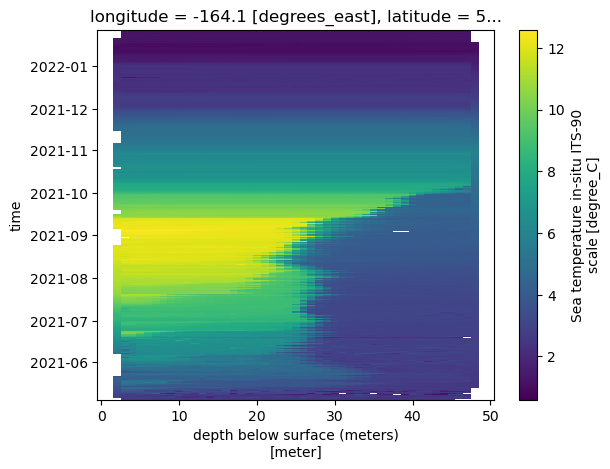

In [46]:
praw_nc.temperature.plot()

In [47]:
praw_nc.to_netcdf(path=datafile.replace('.nc','.edited.nc').replace('working','final_data_cf'),
                  format="NETCDF3_CLASSIC",
                  encoding={'time':{'units':'days since 1900-01-01'}})

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_47388/483832218.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'hours' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  praw_nc.to_netcdf(path=datafile.replace('.nc','.edited.nc').replace('working','final_data_cf'),
